# Quality Assessment

In [25]:
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.graph_objs as go

### ML Performance

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

def eval_rf(trn, hol):
    trn = trn.copy()
    hol = hol.copy()
    col_target = 'income'
    trn_target = trn.pop(col_target)
    hol_target = hol.pop(col_target)
    cat_ix = hol.select_dtypes(include=['object', 'bool']).columns
    num_ix = hol.select_dtypes(include=['int64', 'float64']).columns    
    preproc = ColumnTransformer(
        [("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_ix),
         ("num", MinMaxScaler(), num_ix)],
    )
    model = GradientBoostingClassifier(random_state=0)
    pipe = Pipeline(steps=[('p', preproc), ('m', model)])
    pipe.fit(trn, trn_target)
    probs = pipe.predict_proba(hol)[:,1]
    auc = roc_auc_score(hol_target, probs)
    return auc

def reject_invalid_rules(df, rules):
    for rule in rules:
        df = pd.merge(df, rule.assign(invalid=True), how='left')
        df = df.loc[df.invalid.isna(),:].drop(columns=['invalid'])
    return df


In [27]:
res = []
for i in range(10):
    print(i)
    run_dir = Path('runs') / str(i)
    hol = pd.read_csv(run_dir / 'adult_original_holdout.csv.gz')
    tgt = pd.read_csv(run_dir / 'adult_original_2k.csv.gz')
    syn = pd.read_csv(run_dir / 'adult_synthetic.csv.gz')
    rules = [pd.read_csv(fn) for fn in Path('rules').glob('*.csv')]
    syn_reject = reject_invalid_rules(syn, rules)
    syn_small = syn.sample(n=tgt.shape[0], random_state=1)
    syn_trn = pd.read_csv(run_dir / 'adult_synthetic_trn.csv.gz')
    syn_gen = pd.read_csv(run_dir / 'adult_synthetic_gen.csv.gz')
    syn_trn_gen = pd.read_csv(run_dir / 'adult_synthetic_trn_gen.csv.gz')
    tgt_large = tgt.sample(n=syn.shape[0], replace=True, random_state=0)
    tgt_auc = eval_rf(tgt, hol)
    syn_auc = eval_rf(syn, hol)
    tgt_large_auc = eval_rf(tgt_large, hol)
    syn_reject_auc = eval_rf(syn_reject, hol)
    syn_small_auc = eval_rf(syn_small, hol)
    syn_trn_auc = eval_rf(syn_trn, hol)
    syn_gen_auc = eval_rf(syn_gen, hol)
    syn_trn_gen_auc = eval_rf(syn_trn_gen, hol)
    res.append(pd.DataFrame({
        'run_id': [i],
        'tgt_auc': [tgt_auc],
        'tgt_large_auc': [tgt_large_auc],
        'syn_auc': [syn_auc],
        'syn_reject_auc': [syn_reject_auc],
        'syn_small_auc': [syn_small_auc],
        'syn_auc': [syn_auc],
        'syn_trn_auc': [syn_trn_auc],
        'syn_gen_auc': [syn_gen_auc],
        'syn_trn_gen_auc': [syn_trn_gen_auc],
    }))

results = pd.concat(res, axis=0)

0
1
2
3
4
5
6
7
8
9


In [28]:
results

,run_id,tgt_auc,tgt_large_auc,syn_auc,syn_reject_auc,syn_small_auc,syn_trn_auc,syn_gen_auc,syn_trn_gen_auc
0,0,0.868158,0.868239,0.868073,0.868071,0.856006,0.869699,0.868536,0.870138
0,1,0.864693,0.864268,0.868577,0.868832,0.856951,0.868769,0.868277,0.868680
0,2,0.866812,0.866483,0.869458,0.869428,0.859099,0.869634,0.870044,0.869669
0,3,0.865255,0.863649,0.871428,0.871452,0.863992,0.871109,0.870556,0.870067
0,4,0.866847,0.866697,0.870307,0.870025,0.862765,0.869499,0.870708,0.869454
0,5,0.866929,0.866454,0.867685,0.868054,0.859155,0.868226,0.867865,0.868959
0,6,0.867828,0.867243,0.869278,0.869128,0.859270,0.869580,0.869728,0.869603
0,7,0.865326,0.865968,0.870017,0.869516,0.859529,0.869351,0.869355,0.870048
0,8,0.864918,0.864744,0.869688,0.869579,0.858940,0.869285,0.870220,0.870547
0,9,0.866148,0.865806,0.870037,0.869778,0.858724,0.869262,0.869531,0.869904


In [29]:
results.mean().round(4), results.std().round(4)

(run_id             4.5000
 tgt_auc            0.8663
 tgt_large_auc      0.8660
 syn_auc            0.8695
 syn_reject_auc     0.8694
 syn_small_auc      0.8594
 syn_trn_auc        0.8694
 syn_gen_auc        0.8695
 syn_trn_gen_auc    0.8697
 dtype: float64,
 run_id             3.0277
 tgt_auc            0.0012
 tgt_large_auc      0.0014
 syn_auc            0.0011
 syn_reject_auc     0.0010
 syn_small_auc      0.0024
 syn_trn_auc        0.0007
 syn_gen_auc        0.0010
 syn_trn_gen_auc    0.0006
 dtype: float64)

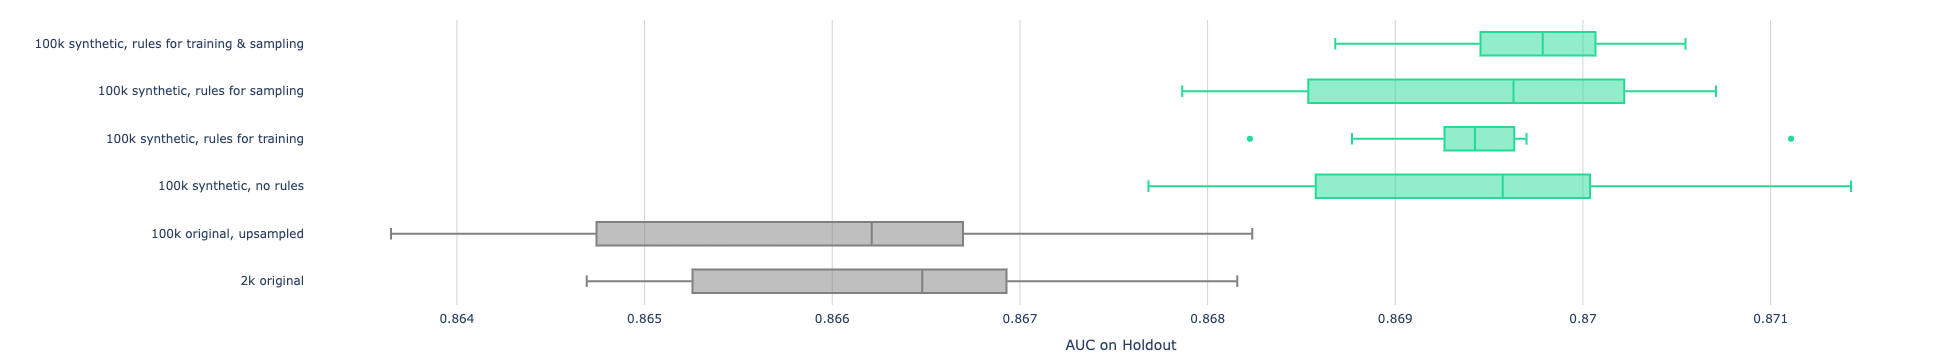

In [31]:
layout = go.Layout(
        #title="Model Performance on Actual Holdout",
        yaxis_title="",
        xaxis_title="AUC on Holdout",
        plot_bgcolor="rgba(0,0,0,0)",
        autosize=False,
        height=230,
        width=800,
        margin=dict(l=10, r=10, b=10, t=20, pad=5),
        showlegend=False,
        xaxis=dict(showgrid=True, showticklabels=True, gridcolor='lightgray'),
    )
fig = go.Figure(layout=layout)
fig.add_trace(go.Box(x=results.tgt_auc, name='2k original', marker=dict(color="gray", size=6)))
fig.add_trace(go.Box(x=results.tgt_large_auc, name='100k original, upsampled', marker=dict(color="gray", size=6)))
#fig.add_trace(go.Box(x=results.syn_small_auc, name='2k synthetic, no rules', marker=dict(color="#24DB96", size=6)))
#fig.add_trace(go.Box(x=results.syn_reject_auc, name='<100k synthetic, rules via rejection', marker=dict(color="#24DB96", size=6)))
fig.add_trace(go.Box(x=results.syn_auc, name='100k synthetic, no rules', marker=dict(color="#24DB96", size=6)))
fig.add_trace(go.Box(x=results.syn_trn_auc, name='100k synthetic, rules for training', marker=dict(color="#24DB96", size=6)))
fig.add_trace(go.Box(x=results.syn_gen_auc, name='100k synthetic, rules for sampling', marker=dict(color="#24DB96", size=6)))
fig.add_trace(go.Box(x=results.syn_trn_gen_auc, name='100k synthetic, rules for training & sampling', marker=dict(color="#24DB96", size=6)))
fig.write_image("figures/adult_aucs.png")
fig.show()

### Descriptive Statistics

In [4]:
def plot_heats(run_dir, col1, col2):
    
    run_dir = Path(run_dir)
    tgt = pd.read_csv(run_dir / 'adult_original_2k.csv.gz')
    syn = pd.read_csv(run_dir / 'adult_synthetic.csv.gz')
    syn_trn = pd.read_csv(run_dir / 'adult_synthetic_trn.csv.gz')
    syn_gen = pd.read_csv(run_dir / 'adult_synthetic_gen.csv.gz')

    tgt['AGE'] = np.where(tgt.age < 32, tgt.age, '32y+')
    syn['AGE'] = np.where(syn.age < 32, syn.age, '32y+')
    syn_trn['AGE'] = np.where(syn_trn.age <= 32, syn_trn.age, '32y+')
    syn_gen['AGE'] = np.where(syn_gen.age <= 32, syn_gen.age, '32y+')

    layout = go.Layout(
        title=col1 + ' ~ ' + col2,
        plot_bgcolor="rgba(0,0,0,0)",
        autosize=False,
        height=900,
        width=1100,
        margin=dict(l=10, r=10, b=10, t=80, pad=5),
        showlegend=False,
    )
    fig = go.Figure(layout=layout).set_subplots(
        rows=2,
        cols=2,
        horizontal_spacing=0.05,
        vertical_spacing=0.15,
        shared_yaxes=True,
        shared_xaxes=True,
        subplot_titles=("2k original", 
                        "100k synthetic, no rules", 
                        "100k synthetic, rules for training", 
                        "100k synthetic, rules for sampling"),
    )
    grid = pd.merge(tgt[col1].drop_duplicates(), tgt[col2].drop_duplicates(), how='cross').sort_values([col1, col2])

    def heat(grid, data):
        col1 = grid.columns[0]
        col2 = grid.columns[1]
        df = data[[col1, col2]].value_counts().to_frame('cnt').reset_index()
        df = pd.merge(grid, df, how='left')
        df["share_by_row"] = df["cnt"] / df.groupby(col1)["cnt"].transform("sum")
        heat = go.Heatmap(
            x=df[col2],
            y=df[col1],
            z=df["share_by_row"],
            text=df["cnt"],
            texttemplate="%{text}",
            textfont={"size": 9},
            zmin=0,
            zmax=1,
            colorscale=["white", "#A7A7A7", "#7B7B7B", "#666666"],
            showscale=False,
        )
        return heat

    fig.add_trace(heat(grid, tgt), row=1, col=1)
    fig.add_trace(heat(grid, syn), row=1, col=2)
    fig.add_trace(heat(grid, syn_trn), row=2, col=1)
    fig.add_trace(heat(grid, syn_gen), row=2, col=2)
    fig.update_xaxes(tickangle=30, showticklabels = True, type = 'category')
    return fig

def calc_invalid_rules(fn):
    rules = pd.read_csv(fn).assign(invalid=True)
    res = []
    for i in range(10):
        run_dir = Path('runs') / str(i)
        hol = pd.read_csv(run_dir / 'adult_original_holdout.csv.gz')
        tgt = pd.read_csv(run_dir / 'adult_original_2k.csv.gz')
        syn = pd.read_csv(run_dir / 'adult_synthetic.csv.gz')
        syn_small = syn.sample(n=tgt.shape[0], random_state=0)
        syn_trn = pd.read_csv(run_dir / 'adult_synthetic_trn.csv.gz')
        syn_gen = pd.read_csv(run_dir / 'adult_synthetic_gen.csv.gz')
        syn_trn_gen = pd.read_csv(run_dir / 'adult_synthetic_trn_gen.csv.gz')
        datasets = {'tgt': tgt, 'syn': syn, 'syn_trn': syn_trn, 'syn_gen': syn_gen, 'syn_trn_gen': syn_trn_gen}
        res.append(pd.DataFrame({key: [1-(pd.merge(df, rules, how='left').invalid.isna()).mean()] for key, df in datasets.items()}))
    return pd.concat(res, axis=0)

#### Rule 1: relationship ~ marital-status

In [5]:
calc_invalid_rules('rules/rule1.csv').mean().round(4)

tgt            0.0000
syn            0.0011
syn_trn        0.0001
syn_gen        0.0000
syn_trn_gen    0.0000
dtype: float64

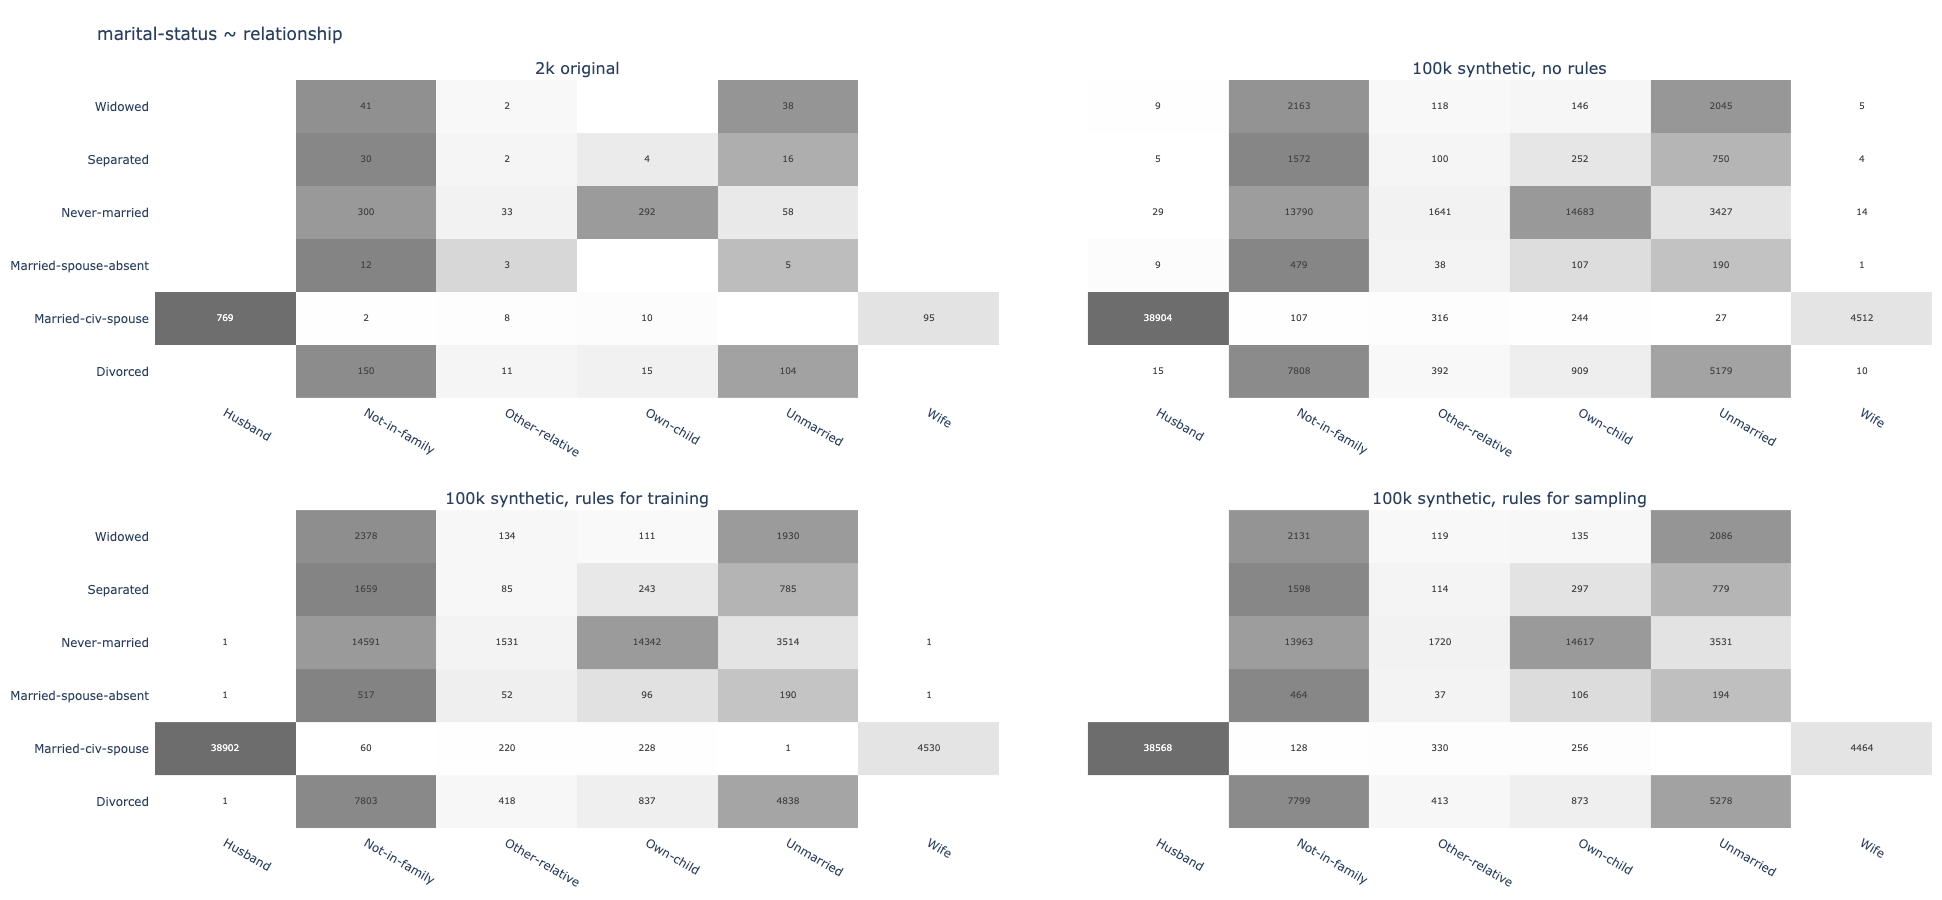

In [64]:
fig = plot_heats('runs/0', 'marital-status', 'relationship')
fig.write_image("figures/adult_relationship.png")
fig

### Rule 2: education ~ education.num

In [7]:
calc_invalid_rules('rules/rule2.csv').mean().round(4)

tgt            0.0000
syn            0.0157
syn_trn        0.0079
syn_gen        0.0000
syn_trn_gen    0.0000
dtype: float64

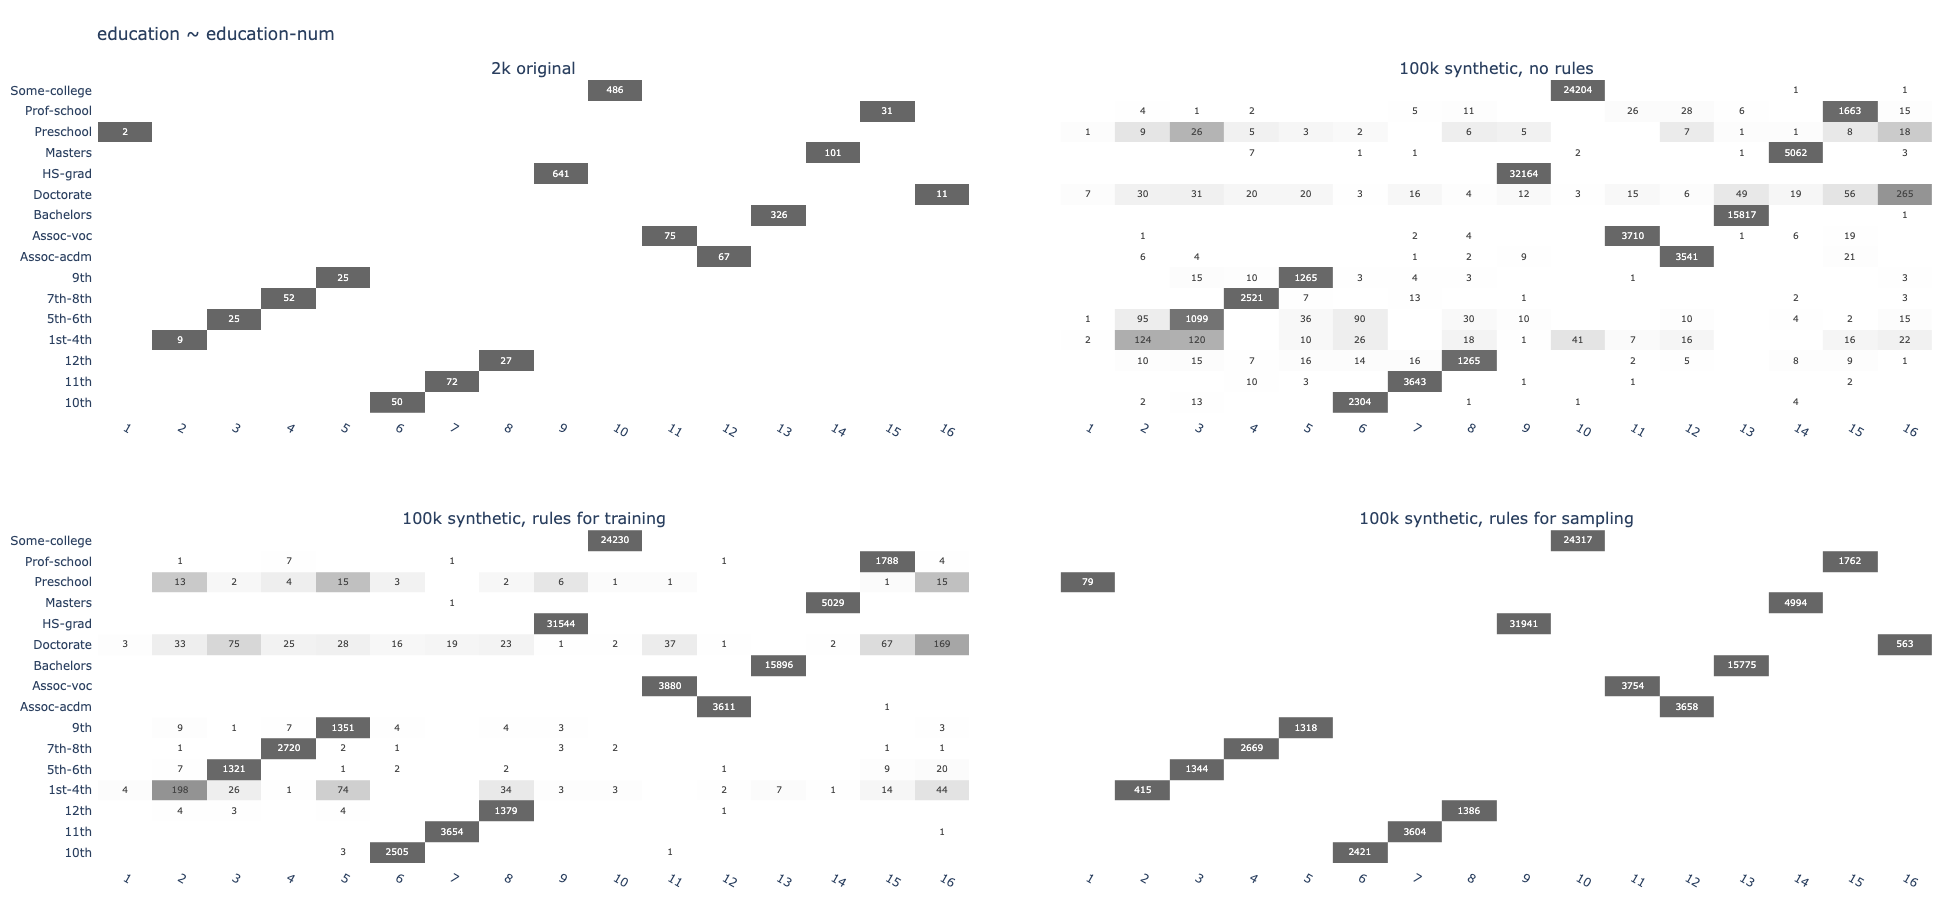

In [66]:
fig = plot_heats('runs/0', 'education', 'education-num')
fig.write_image("figures/adult_education.png")
fig

### Rule 3: education ~ age

In [8]:
calc_invalid_rules('rules/rule3.csv').mean().round(4)

tgt            0.0000
syn            0.0007
syn_trn        0.0002
syn_gen        0.0000
syn_trn_gen    0.0000
dtype: float64

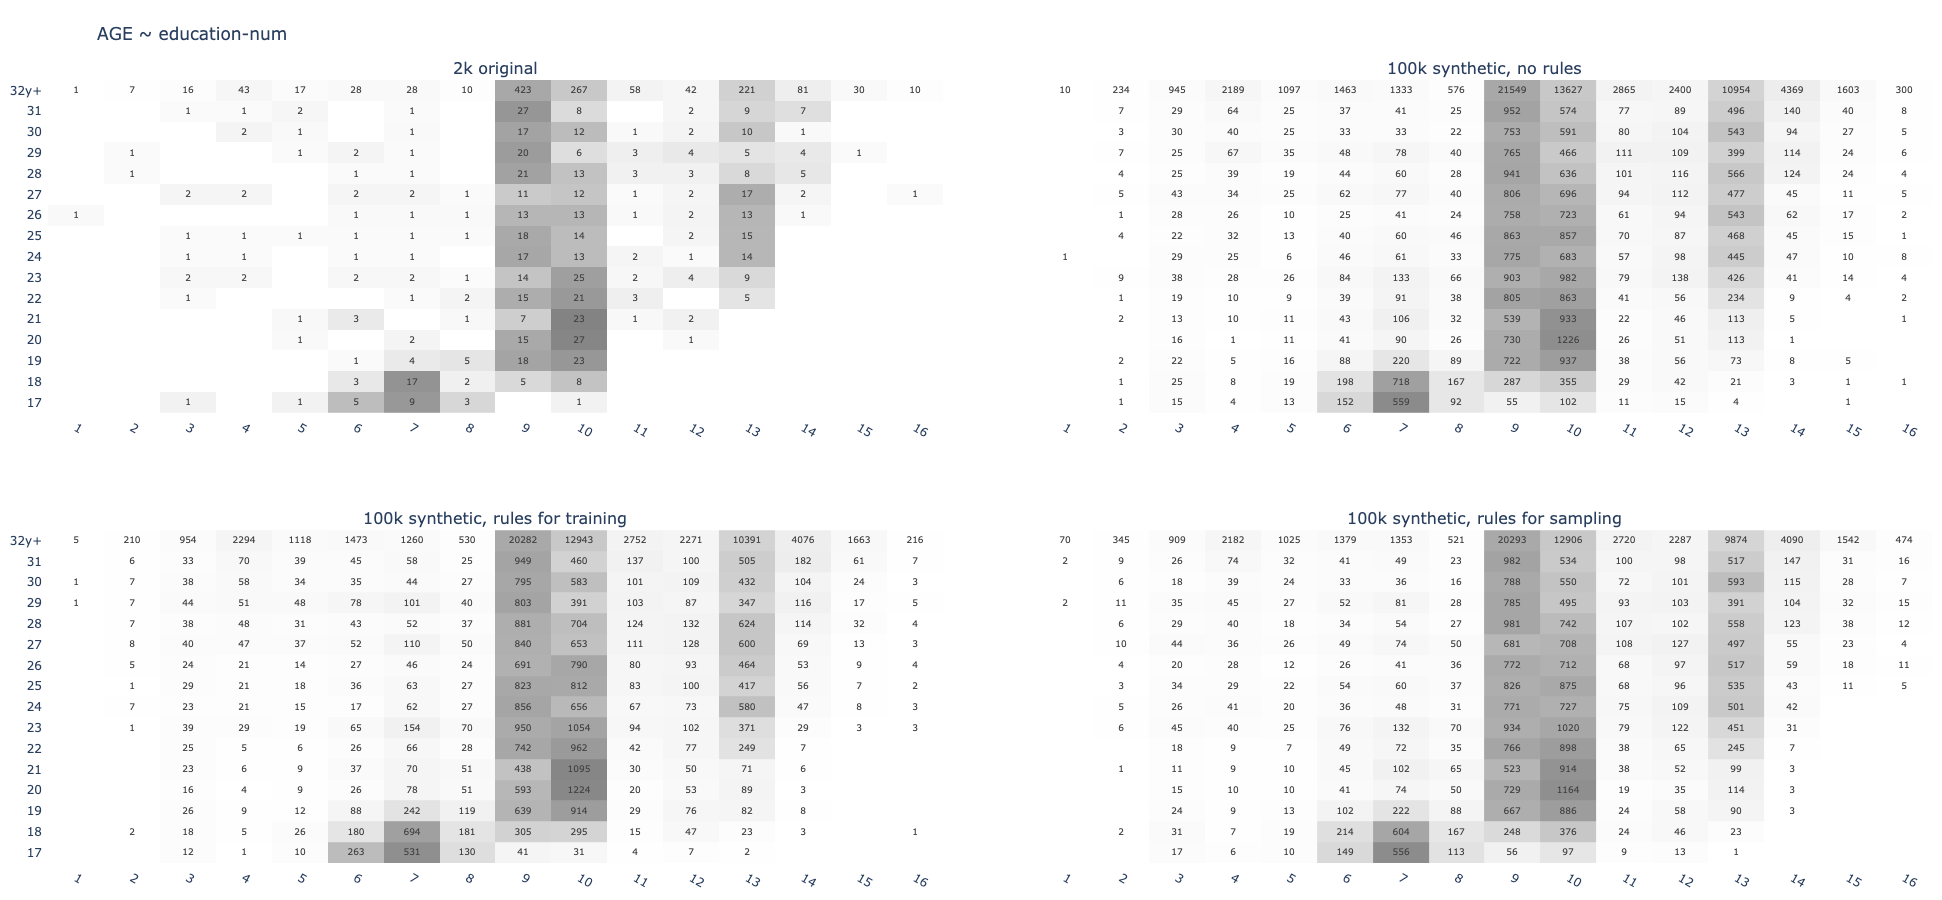

In [68]:
fig = plot_heats('runs/0', 'AGE', 'education-num')
fig.write_image("figures/adult_age.png")
fig

### Rule 4: relationship ~ sex

In [9]:
calc_invalid_rules('rules/rule4.csv').mean().round(5)

tgt            0.00005
syn            0.00061
syn_trn        0.00003
syn_gen        0.00000
syn_trn_gen    0.00000
dtype: float64

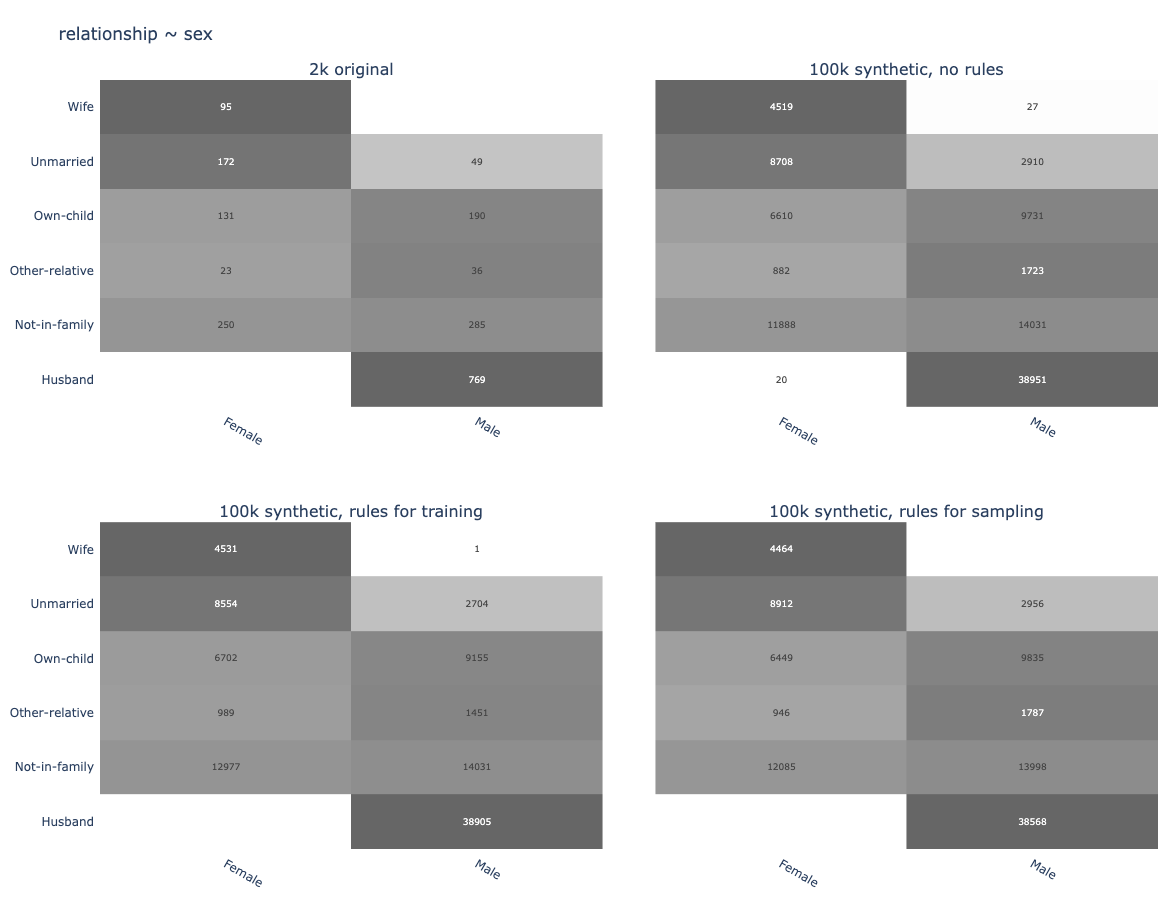

In [70]:
fig = plot_heats('runs/0', 'relationship', 'sex')
fig.write_image("figures/adult_gender.png")
fig